# Make query and document embeddings using (Skills-/Col-) BERT
This notebook will preprocess data and tokenize queries and documents before sending it all through a BERT model to obtain embeddings. The embeddings of quries and documents are stored locally in order to load them for training a new final linear layer on top of BERT and later to compute similarity scores.

In [1]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp keras scikit-learn matplotlib tensorflow

#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 

In [17]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import time
% matplotlib inline

UsageError: Line magic function `%` not found.


In [3]:
# Load data
df = pd.read_csv(r'.\data\skills_description.csv', sep='\t', encoding='utf-8')
df = df.rename(columns={'preferredLabel':'query', 'description': 'documents'})
df = df[['query', 'documents']]

df.head()

,query,documents
0,lede musikalsk personale,Tildele og forvalte personaleopgaver på område...
1,føre tilsyn med fængselsprocedurer,Føre tilsyn med driften af et fængsel eller an...
2,anvende antioppressiv praksis,"Identificere undertrykkelse i samfund, økonomi..."
3,kontrollere overensstemmelse med jernbaneforsk...,"Inspicere rullende materiel, komponenter og sy..."
4,identificere tilgængelige tjenester,"Identificere de forskellige tjenester, der er ..."


### Specify device

In [4]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device=="cuda":
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
    print(f'Running on {device} with {n_gpu} number of GPUs')
else:
    print(f'Running on {device}. Be patient...')

Running on cpu. Be patient...


### Add special tokens to sequences

In [6]:
# add special ColBERT tokens to queries and documents
queries = ["[CLS] " + query + " [SEP]" for query in df['query']]
documents =  ["[CLS] " + query + " [SEP]" for query in df['documents']]
print("Example of query:\n", queries[0])
print("\nExample of document:\n", documents[0])


Example of query:
 [CLS] lede musikalsk personale [SEP]

Example of document:
 [CLS] Tildele og forvalte personaleopgaver på områder såsom instrumentering, bearbejdning, reproduktion af musik og stemmetræning. [SEP]


### Load BERT tokenizer
The BERT tokenizer is very storage efficient way of splitting a sequence into words - or rather tokens of subwords. The tokenizer uses WordPiece which uses subwords. That is splitting words into multiple words in order to keep the vocabulary smaller. That way, the vocabulary does not need to keep both: "boy" and "boys" but only "boy" and "s" where "s" can be used in many other cases.

In [10]:
# Tokenize with BERT tokenizer
model_path = r'J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish_bert_uncased_v2'
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=True)

# Tokenize queries and documents
tokenized_texts = [tokenizer.tokenize(sent) for sent in queries]
tokenized_docs = [tokenizer.tokenize(doc) for doc in documents]

print(f'Tokenized first sentence: \n {tokenized_texts[0]}')
print (f'\nTokenized first document: \n {tokenized_docs[0]}')

Tokenized first sentence: 
 ['[CLS]', 'lede', 'musikalsk', 'personale', '[SEP]']

Tokenized first document: 
 ['[CLS]', 'tildele', 'og', 'forvalt', '##e', 'personale', '##opgaver', 'pa', 'om', '##rad', '##er', 'sas', '##om', 'instrumenter', '##ing', ',', 'bearbejdning', ',', 'reproduktion', 'af', 'musik', 'og', 'stemme', '##træning', '.', '[SEP]']


### Decide on length og sequences for queries and documents
Below the length of sequences are plottet.
Based on eye-balling the plot the maximum sequence length of queries and documents are determined to 24 and 128, respectively.
Note that this is a hyperparameter determined by the researcher.

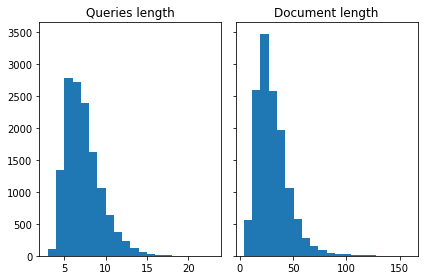

In [30]:
# Length of sequences
len_queries = [len(x) for x in tokenized_texts]
len_documents = [len(x) for x in tokenized_docs]

# Plot length of queries and documents
n_bins = 20

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(len_queries, bins=n_bins)
axs[0].set_title('Queries length',fontsize=12)
axs[1].hist(len_documents, bins=n_bins)
axs[1].set_title('Document length',fontsize=12)
plt.show()

### Convert tokens to ids 
- Now assign ids to the tokens that the respective subword in the vocabulary (see seperate vocab file associated with the model).
- Also pad input sequences to predetermined length 24 and 128 - from above.
- Keep track of what is padded and masked

In [13]:
# Set the maximum query length. 
MAX_LEN_Q = 24

# Pad our input tokens
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
q_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
q_input_ids = pad_sequences(q_input_ids, maxlen=MAX_LEN_Q, dtype="long", truncating="post", padding="post")
print(f'Shape of query ids:\n q_input_ids.shape = {q_input_ids.shape}')


# Create query attention masks
q_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in q_input_ids:
  seq_mask = [float(i>0) for i in seq]
  q_attention_masks.append(seq_mask)

print(f'Shape of query attention mask:\n q_attention_masks = {np.shape(q_attention_masks)}')

assert q_input_ids.shape == np.shape(q_attention_masks), 'dimensions of q_input_ids and q_attention_mask do not match' 

Shape of query ids:
 q_input_ids.shape = (13485, 24)
Shape of query attention mask:
 q_attention_masks = (13485, 24)


In [14]:
# Set the maximum document length. 
MAX_LEN_DOC = 128
# Pad our input tokens
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
d_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_docs]
d_input_ids = pad_sequences(d_input_ids, maxlen=MAX_LEN_DOC, dtype="long", truncating="post", padding="post")
print(f'Shape of input_ids.shape: {d_input_ids.shape}')


# Create attention masks for documents
d_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in d_input_ids:
  seq_mask = [float(i>0) for i in seq]
  d_attention_masks.append(seq_mask)

print(f'Shape of d_attention_masks: {np.shape(d_attention_masks)}')

assert d_input_ids.shape == np.shape(d_attention_masks), 'dimensions of document d_input_ids and d_attention_mask do not match' 

Shape of input_ids.shape: (13485, 128)
Shape of d_attention_masks: (13485, 128)


# Import model
Queries and documents have now been tokenized to the vocabolary

In [15]:
from transformers import BertConfig
from transformers import BertModel

config = BertConfig.from_pretrained(model_path + r'\bert_config.json')
bert_base = BertModel(config)

In [18]:
from torch import nn
import torch.nn.functional as F

class SkillsColBERT(nn.Module):
    def __init__(self):
          super(SkillsColBERT, self).__init__()
          self.bert = bert_base 
          ### New layers:
          #TODO: 
          # self.finalLinear = nn.Linear(768, 32) # 32 is "low" for faster computation of MaxSim (it is independent of sequence lentgh)
          

    def forward(self, ids, mask):
          sequence_output, pooled_output = self.bert(ids, attention_mask=mask) # sequence_output shape is: (batch_size, sequence_length, 768)
               
          # We apply the linear layer in line with ColBERT paper. The linear layer (which applies a linear transformation)
          # takes as input the hidden states of all tokens (so seq_len times a vector of size 768, each corresponding to
          # a single token in the input sequence) and outputs 32 numbers for every token
          # so the logits are of shape (batch_size, sequence_length, 32)
          
          #TODO: 
          # sequence_output = self.finalLinear(sequence_output)
          sequence_output = F.softmax(sequence_output, dim=1)

          return sequence_output

## Create Embeddings for queries and documents:

### Process documents through BERT model to get embeddings

In [12]:
# Choose batch_size
stide_len = 100

my_model  = SkillsColBERT()
my_model.to(torch.device(device))


# Initialize tensor to store output
d_id    = torch.tensor(d_input_ids[:stide_len]).to(torch.device(device)).to(torch.int64)
d_mask  = torch.tensor(d_attention_masks[:stide_len]).to(torch.device(device)).to(torch.int64)
doc_output = my_model(d_id, mask=d_mask)

step = 0
i = 0
start_time = time.time()
while step < len(df):
    if os.path.exists(os.path.join(os.getcwd(), 'doc_embeddings', f'tensor_{i}.pt')):
        step += stide_len
        i += 1
    else:
        if step % (500)==0:
            print(f'batch {i} of size {stide_len} out of {len(df)/stide_len}')

        d_id    = torch.tensor(d_input_ids[step:step+stide_len]).to(torch.device(device)).to(torch.int64)
        d_mask  = torch.tensor(np.array(d_attention_masks[step:step+stide_len])).to(torch.device(device)).to(torch.int64)

        # Find Embeddings of documents and save to disk
        torch.save(my_model(d_id, mask=d_mask), f'./doc_embeddings/tensor_{i}.pt')

        # Add stride_length to step
        step += stide_len
        i += 1

end_time = time.time()
print("total time taken this loop: ", end_time - start_time)

batch 0 of size 100 out of 134.85
batch 1 of size 100 out of 134.85
batch 2 of size 100 out of 134.85
batch 3 of size 100 out of 134.85
batch 4 of size 100 out of 134.85
batch 5 of size 100 out of 134.85
batch 6 of size 100 out of 134.85
batch 7 of size 100 out of 134.85
batch 8 of size 100 out of 134.85
batch 9 of size 100 out of 134.85
batch 10 of size 100 out of 134.85
batch 11 of size 100 out of 134.85
batch 12 of size 100 out of 134.85
batch 13 of size 100 out of 134.85
batch 14 of size 100 out of 134.85
batch 15 of size 100 out of 134.85
batch 16 of size 100 out of 134.85
batch 17 of size 100 out of 134.85
batch 18 of size 100 out of 134.85
batch 19 of size 100 out of 134.85
batch 20 of size 100 out of 134.85
batch 21 of size 100 out of 134.85
batch 22 of size 100 out of 134.85
batch 23 of size 100 out of 134.85
batch 24 of size 100 out of 134.85
batch 25 of size 100 out of 134.85
batch 26 of size 100 out of 134.85
batch 27 of size 100 out of 134.85
batch 28 of size 100 out of 13

### Reload document embeddings
- Reload tensors to collect them into one big.

In [20]:
load_doc_embeddings = torch.load(f'./doc_embeddings/tensor_{0}.pt')

i = 1
while os.path.exists(os.path.join(os.getcwd(), 'doc_embeddings', f'tensor_{i}.pt')):
    if i % (20)==0:
        print(f'loading document embedding {i}')
    
    load_doc_embeddings = torch.cat((load_doc_embeddings, torch.load(f'./doc_embeddings/tensor_{i}.pt')), 0)
    i += 1

loading document embedding 20
loading document embedding 40
loading document embedding 60
loading document embedding 80
loading document embedding 100
loading document embedding 120


In [21]:
load_doc_embeddings.shape

torch.Size([13485, 128, 768])

In [ ]:
# Save the full tensor
torch.save(load_doc_embeddings, f'./doc_embeddings/doc_tensor.pt')

### Embed queries

In [27]:
# Choose batch_size
stide_len = 100

my_model  = SkillsColBERT()
my_model.to(torch.device(device))


# Initialize tensor to store output
q_id    = torch.tensor(q_input_ids[:stide_len]).to(torch.device(device)).to(torch.int64)
q_mask  = torch.tensor(q_attention_masks[:stide_len]).to(torch.device(device)).to(torch.int64)
doc_output = my_model(q_id, mask=q_mask)

step = 0
i = 0
start_time = time.time()
while step < len(df):
    if os.path.exists(os.path.join(os.getcwd(), 'query_embeddings', f'tensor_{i}.pt')):
        step += stide_len
        i += 1
    else:
        if step % (20)==0:
            print(f'batch {i} of size {stide_len} out of {len(df)/stide_len}')

        q_id    = torch.tensor(q_input_ids[step:step+stide_len]).to(torch.device(device)).to(torch.int64)
        q_mask  = torch.tensor(np.array(q_attention_masks[step:step+stide_len])).to(torch.device(device)).to(torch.int64)

        # Find Embeddings of documents and save to disk
        torch.save(my_model(q_id, mask=q_mask), f'./query_embeddings/tensor_{i}.pt')

        # Add stride_length to step
        step += stide_len
        i += 1

end_time = time.time()
print("total time taken this loop: ", end_time - start_time)

batch 0 of size 100 out of 134.85
batch 5 of size 100 out of 134.85
batch 10 of size 100 out of 134.85
batch 15 of size 100 out of 134.85
batch 20 of size 100 out of 134.85
batch 25 of size 100 out of 134.85
batch 30 of size 100 out of 134.85
batch 35 of size 100 out of 134.85
batch 40 of size 100 out of 134.85
batch 45 of size 100 out of 134.85
batch 50 of size 100 out of 134.85
batch 55 of size 100 out of 134.85
batch 60 of size 100 out of 134.85
batch 65 of size 100 out of 134.85
batch 70 of size 100 out of 134.85
batch 75 of size 100 out of 134.85
batch 80 of size 100 out of 134.85
batch 85 of size 100 out of 134.85
batch 90 of size 100 out of 134.85
batch 95 of size 100 out of 134.85
batch 100 of size 100 out of 134.85
batch 105 of size 100 out of 134.85
batch 110 of size 100 out of 134.85
batch 115 of size 100 out of 134.85
batch 120 of size 100 out of 134.85
batch 125 of size 100 out of 134.85
batch 130 of size 100 out of 134.85
total time taken this loop:  1069.488811969757


### Reload query embeddings
- Reload all batched tensors to collect them into one big and save that.

In [28]:
load_query_embeddings = torch.load(f'./query_embeddings/tensor_{0}.pt')

i = 1
while os.path.exists(os.path.join(os.getcwd(), 'query_embeddings', f'tensor_{i}.pt')):
    if i % (20)==0:
        print(f'loading query embedding {i}')
    
    load_query_embeddings = torch.cat((load_query_embeddings, torch.load(f'./query_embeddings/tensor_{i}.pt')), 0)
    i += 1

print('Last batch run: ', i)
print('Shape of :', load_query_embeddings.shape)

loading query embedding 20
loading query embedding 40
loading query embedding 60
loading query embedding 80
loading query embedding 100
loading query embedding 120
Last batch run:  135
Shape of : torch.Size([13485, 24, 768])


In [29]:
# Save the full tensor  (~3 GB)
torch.save(load_query_embeddings, f'./query_embeddings/query_tensor.pt')